In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies-and-series-rating-from-imdb/title.basics.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.episode.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.principals.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.ratings.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/name.basics.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.akas.tsv/data.tsv
/kaggle/input/movies-and-series-rating-from-imdb/title.crew.tsv/data.tsv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

In [3]:
basics_path  = "/kaggle/input/movies-and-series-rating-from-imdb/title.basics.tsv/data.tsv"
ratings_path = "/kaggle/input/movies-and-series-rating-from-imdb/title.ratings.tsv/data.tsv"

basics  = pd.read_csv(basics_path, sep="\t", low_memory=False)
ratings = pd.read_csv(ratings_path, sep="\t", low_memory=False)

basics.shape, ratings.shape

((9811401, 9), (1306113, 3))

In [4]:
basics = basics[['tconst', 'titleType', 'startYear', 'runtimeMinutes', 'isAdult']].copy()
ratings = ratings[['tconst', 'averageRating', 'numVotes']].copy()

In [5]:
df = basics.merge(ratings, on='tconst', how='inner')
df.shape

(1306106, 7)

In [6]:
num_cols = ['startYear', 'runtimeMinutes', 'isAdult', 'averageRating', 'numVotes']

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=num_cols).copy()
df.shape

(934302, 7)

In [7]:
df.head()

,tconst,titleType,startYear,runtimeMinutes,isAdult,averageRating,numVotes
0,tt0000001,short,1894.0,1.0,0,5.7,1966
1,tt0000002,short,1892.0,5.0,0,5.8,264
2,tt0000003,short,1892.0,4.0,0,6.5,1810
3,tt0000004,short,1892.0,12.0,0,5.6,178
4,tt0000005,short,1893.0,1.0,0,6.2,2610


In [8]:
df['completed'] = (df['averageRating'] > 7).astype(int)
df['completed'].value_counts(normalize=True)

completed
1    0.502323
0    0.497677
Name: proportion, dtype: float64

In [9]:
df['titleType_code'] = df['titleType'].astype('category').cat.codes

feature_cols = ['numVotes', 'runtimeMinutes', 'startYear', 'isAdult', 'titleType_code']

df_nn = df[feature_cols + ['completed']].copy()
df_nn.head()

,numVotes,runtimeMinutes,startYear,isAdult,titleType_code,completed
0,1966,1.0,1894.0,0,1,0
1,264,5.0,1892.0,0,1,0
2,1810,4.0,1892.0,0,1,0
3,178,12.0,1892.0,0,1,0
4,2610,1.0,1893.0,0,1,0


In [10]:
X = df_nn[feature_cols]
y = df_nn['completed'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_test  = y_test.values.reshape(-1, 1)

X_train.shape, y_train.shape

((747441, 5), (747441, 1))

**NN from scratch**

In [11]:
class NeuralNetScratch:
    def __init__(self, input_size=5, hidden_size=5, lr=0.05, epochs=2000):
        self.lr = lr
        self.epochs = epochs
        self.losses = []

        rng = np.random.default_rng(42)
        self.W1 = rng.normal(0, 0.1, size=(input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = rng.normal(0, 0.1, size=(hidden_size, hidden_size))
        self.b2 = np.zeros((1, hidden_size))

        self.W3 = rng.normal(0, 0.1, size=(hidden_size, 1))
        self.b3 = np.zeros((1, 1))

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def bce_loss(self, y, yhat):
        eps = 1e-9
        return -np.mean(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps))

    def fit(self, X, y):
        N = X.shape[0]
        self.losses = []

        for _ in range(self.epochs):
            # forward
            Z1 = X @ self.W1 + self.b1
            A1 = self.sigmoid(Z1)

            Z2 = A1 @ self.W2 + self.b2
            A2 = self.sigmoid(Z2)

            Z3 = A2 @ self.W3 + self.b3
            yhat = self.sigmoid(Z3)

            # loss
            self.losses.append(self.bce_loss(y, yhat))

            # backprop
            dZ3 = (yhat - y) / N
            dW3 = A2.T @ dZ3
            db3 = np.sum(dZ3, axis=0, keepdims=True)

            dA2 = dZ3 @ self.W3.T
            dZ2 = dA2 * (A2 * (1 - A2))
            dW2 = A1.T @ dZ2
            db2 = np.sum(dZ2, axis=0, keepdims=True)

            dA1 = dZ2 @ self.W2.T
            dZ1 = dA1 * (A1 * (1 - A1))
            dW1 = X.T @ dZ1
            db1 = np.sum(dZ1, axis=0, keepdims=True)

            # update
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1

        return self

    def predict_proba(self, X):
        A1 = self.sigmoid(X @ self.W1 + self.b1)
        A2 = self.sigmoid(A1 @ self.W2 + self.b2)
        return self.sigmoid(A2 @ self.W3 + self.b3)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [12]:
nn = NeuralNetScratch(input_size=5, hidden_size=5, lr=0.05, epochs=1000)
nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

acc, f1

(0.5023252578119565, 0.66873036341486)

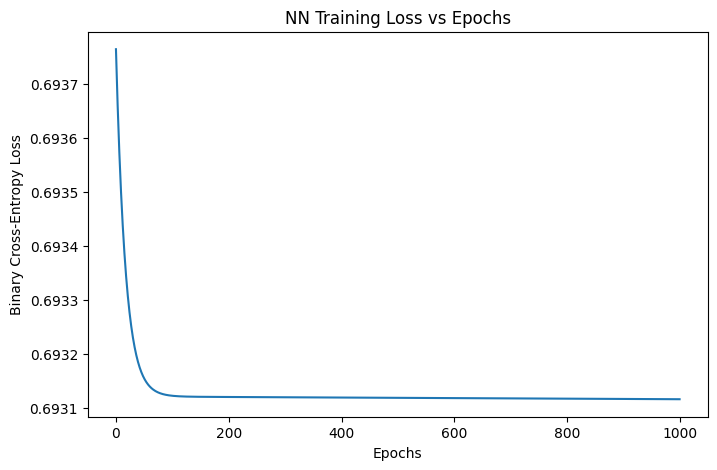

In [13]:
plt.figure(figsize=(8,5))
plt.plot(nn.losses)
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("NN Training Loss vs Epochs")
plt.show()